# Classification Task - Spotify Genre Prediction

**Course:** Machine Learning  
**Professor:** Dr. Moshfeghi  
 

---

## Task 2: Classification - Predicting Song Genre
# Introduction

The goal is to create a machine learning model that predicts a song's genre by analyzing various musical features like tempo, loudness, energy, and danceability. This classification task involves several important steps, starting with a deep dive into the data to understand its structure. The process includes handling missing values, identifying any outliers, and considering feature engineering to improve model accuracy. The primary metric for success will be classification accuracy. Ultimately, the aim is to develop a model that not only classifies songs effectively but also uncovers meaningful insights into how different musical attributes relate to their genres.

## Import necessary libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import normalized_mutual_info_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

**Load and preprocess training dataset**

In [5]:
train_df = pd.read_csv('CS98XClassificationTrain.csv')

**Preview the training dataset**

In [7]:
train_df.head()

,Id,title,artist,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,top genre
0,1,My Happiness,Connie Francis,1996,107,31,45,-8,13,28,150,75,3,44,adult standards
1,2,Unchained Melody,The Teddy Bears,2011,114,44,53,-8,13,47,139,49,3,37,NaN
2,3,How Deep Is Your Love,Bee Gees,1979,105,36,63,-9,13,67,245,11,3,77,adult standards
3,4,Woman in Love,Barbra Streisand,1980,170,28,47,-16,13,33,232,25,3,67,adult standards
4,5,Goodbye Yellow Brick Road - Remastered 2014,Elton John,1973,121,47,56,-8,15,40,193,45,3,63,glam rock


## Dataset Overview

The training dataset contains 453 entries and 15 columns, including audio features (e.g., `bpm`, `nrgy`, `dnce`) and metadata such as `title`, `artist`, and `top genre`.There are no missing values in any of the feature columns. Only the target variable, `top genre`, contains 15 missing entries. These were excluded prior to training, ensuring all models were built on complete data.


In [9]:
train_df.info()
train_df.shape
train_df.isna().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         453 non-null    int64 
 1   title      453 non-null    object
 2   artist     453 non-null    object
 3   year       453 non-null    int64 
 4   bpm        453 non-null    int64 
 5   nrgy       453 non-null    int64 
 6   dnce       453 non-null    int64 
 7   dB         453 non-null    int64 
 8   live       453 non-null    int64 
 9   val        453 non-null    int64 
 10  dur        453 non-null    int64 
 11  acous      453 non-null    int64 
 12  spch       453 non-null    int64 
 13  pop        453 non-null    int64 
 14  top genre  438 non-null    object
dtypes: int64(12), object(3)
memory usage: 53.2+ KB


Id           False
title        False
artist       False
year         False
bpm          False
nrgy         False
dnce         False
dB           False
live         False
val          False
dur          False
acous        False
spch         False
pop          False
top genre     True
dtype: bool

## Handling Missing Values

A total of 15 rows had missing values in the `top genre` column. These were identified using:

```python

# train_df[train_df['top genre'].isna()]

In [11]:
genre_counts = train_df['top genre'].value_counts()
train_df = train_df[train_df['top genre'].isin(genre_counts[genre_counts > 1].index)]

In [12]:
# Drop rows with missing target labels
df = train_df.dropna(subset=['top genre'])

In [13]:
genre_counts = df['top genre'].value_counts()
df_filtered = df[df['top genre'].isin(genre_counts[genre_counts > 1].index)]

In [14]:
# Exploring categorical features using Normalized Mutual Information (NMI)
categorical_types = list(df_filtered.dtypes[df_filtered.dtypes == 'object'].index)
categorical_types.append('year')
for t in categorical_types:
    if t != 'top genre':
        print(f'{t}: {df_filtered[t].nunique()} unique values')
        print(f"Normalized Mutual Information Score: {normalized_mutual_info_score(df_filtered[t], df_filtered['top genre'])}\n")

title: 396 unique values
Normalized Mutual Information Score: 0.6694323670259759

artist: 291 unique values
Normalized Mutual Information Score: 0.7061685862122051

year: 64 unique values
Normalized Mutual Information Score: 0.44664640983914183



## Filtering Rare Genres

Genres that appeared only once in the dataset were excluded from training. This decision was made to reduce noise and avoid training the model on classes it cannot generalize from, as single-instance genres provide no meaningful patterns to learn. This also helps improve model stability and prevents overfitting to outliers.


## Feature Analysis – Categorical Correlation

To assess the relationship between categorical features and the target (`top genre`), Normalized Mutual Information (NMI) was used. This metric helps identify which categorical variables may carry predictive power. Features such as `title` and `artist` had high cardinality and low mutual information. The `year` feature showed moderate dependence and was retained as a numerical feature.

In [17]:
from sklearn.metrics import normalized_mutual_info_score
# Identify categorical variables
categorical_features = list(train_df.select_dtypes(include='object').columns)
categorical_features.append('year')
# Show only those with low cardinality (optional)
for feature in categorical_features:
    if feature != 'top genre' and train_df[feature].nunique() < 50:
        nmi = normalized_mutual_info_score(train_df[feature], train_df['top genre'])
        print(f"{feature}: NMI = {round(nmi, 3)}")

## Distribution of Numerical Features

This grid of histograms displays the distributions of all numerical features in the dataset. Most variables such as `bpm`, `dnce`, and `pop` appear relatively balanced, while others like `acous`, `live`, and `spch` show strong skewness or concentration near zero. Understanding these distributions is important for selecting scaling techniques and for interpreting feature importance later during model evaluation.

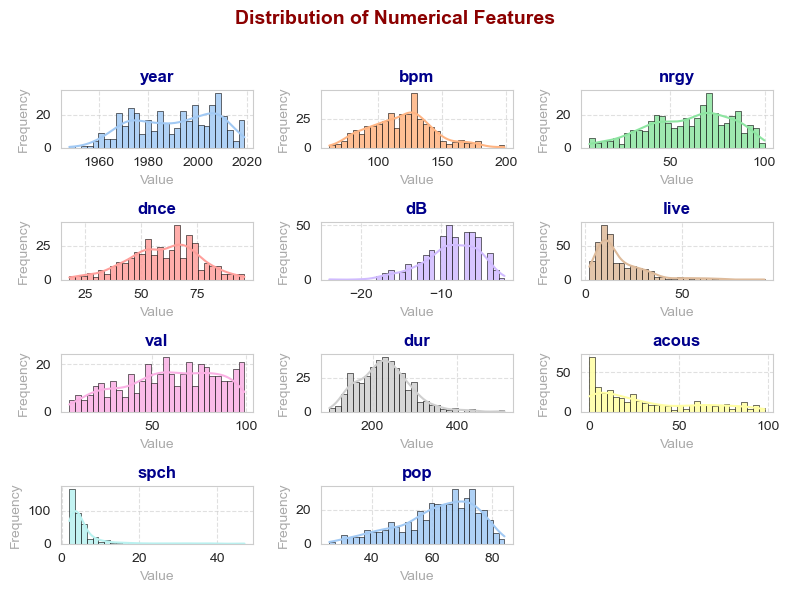

In [92]:
numeric_features = ['year', 'bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch', 'pop']
colors = sns.color_palette("pastel", len(numeric_features))
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=len(numeric_features) // 3 + 1, ncols=3, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    sns.histplot(df_filtered[col], ax=axes[i], bins=30, kde=True, color=colors[i], edgecolor='black', alpha=0.85)
    axes[i].set_title(col, fontsize=12, fontweight='bold', color='darkblue')
    axes[i].set_xlabel('Value', fontsize=10, color='darkgray')
    axes[i].set_ylabel('Frequency', fontsize=10, color='darkgray')
    axes[i].grid(True, linestyle='--', alpha=0.6)

for i in range(len(numeric_features), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle("Distribution of Numerical Features", fontsize=14, fontweight='bold', color='darkred')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Feature Correlation Heatmap

A correlation heatmap was used to examine linear relationships between numerical features. Notably, `nrgy` and `acous` were strongly negatively correlated (-0.66), suggesting energy and acousticness vary inversely. Both `dnce` and `nrgy` showed moderate positive correlation with `pop`, which may help predict song popularity and genre. These insights informed the choice of features to retain and highlight during model training.

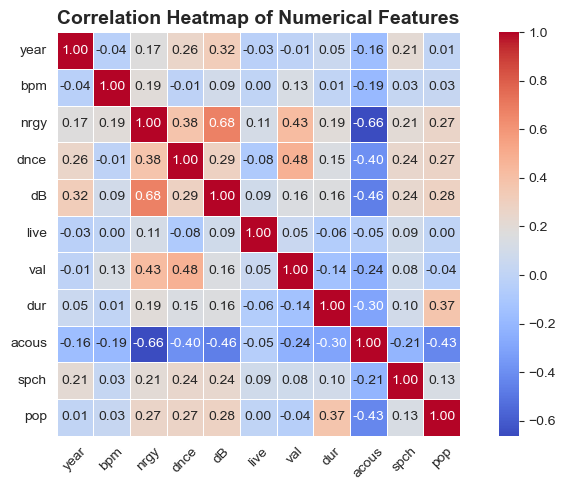

In [82]:
plt.figure(figsize=(8, 5))
corr_matrix = train_df[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Genre Distribution (Top 10)

This plot illustrates the frequency of the top 10 most common genres in the dataset. The genre distribution is highly imbalanced, with a few genres such as `adult standards`, `album rock`, and `dance pop` dominating the dataset. This imbalance justifies the use of evaluation metrics such as macro recall and motivates the consideration of balancing techniques (e.g., oversampling or class weighting) during model training.

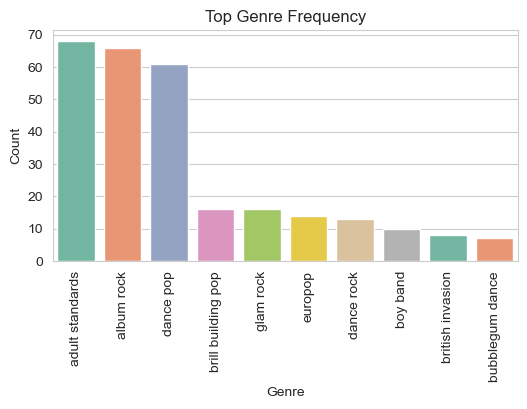

In [76]:
plt.figure(figsize=(6,3))
sns.countplot(x='top genre', data=df_filtered, order=df_filtered['top genre'].value_counts().index[:10], palette='Set2')
plt.title('Top Genre Frequency')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

## Feature Preprocessing and Encoding
The target variable (`top genre`) was encoded using `LabelEncoder` to convert genre labels into numeric classes. For input features, a `ColumnTransformer` was used to preprocess data:
- Numerical features were scaled to [0, 1] using `MinMaxScaler`
- The categorical `artist` feature was one-hot encoded
This preprocessing ensured that all features were on a comparable scale and in a format suitable for training classification models.

## LabelEncoder

In [26]:
# Define features and target
X = df_filtered.drop(['Id', 'title', 'top genre'], axis=1)
y = df_filtered['top genre']

In [27]:
# Encode target variable (genres to numeric)
le_genre = LabelEncoder()
y_encoded = le_genre.fit_transform(y)

In [28]:
# Step 2: Define numerical and categorical features
cat_features = ['artist']

## One Hot Encoder 

In [30]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

In [31]:
# Transform features
X_processed = preprocessor.fit_transform(X)

## Train-Test Split
The processed dataset was split into training and validation sets using an 80/20 split. Stratified sampling was applied to ensure that the distribution of genre classes remained consistent between the training and validation sets. This helps ensure fair evaluation, especially in the presence of class imbalance.


In [33]:
X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Model Selection 
**Train multiple models**

In [35]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    }

In [36]:
accuracies = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    accuracies[name] = acc

## Model Evaluation Summary

Multiple classification models were evaluated using three metrics: accuracy, macro-averaged recall, and F1-score. Since the dataset is highly imbalanced, macro recall was the primary metric of interest. Gradient Boosting achieved the best performance across all three metrics, with a macro recall of 0.403. Therefore, it was selected as the final model for test prediction and submission.


In [38]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
    results.append({
        'Model': name,
        'Accuracy': round(acc, 3),
        'Macro Recall': round(recall, 3),
        'F1 Score': round(f1, 3)
    })
results_df = pd.DataFrame(results).sort_values(by='Macro Recall', ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df

,Model,Accuracy,Macro Recall,F1 Score
0,Gradient Boosting,0.625,0.403,0.391
1,Random Forest,0.537,0.211,0.210
2,Logistic Regression,0.562,0.197,0.177
3,SVM,0.537,0.192,0.174
4,Decision Tree,0.312,0.173,0.183


## Accuracy Comparison (Visual)

To complement the evaluation table, the bar chart below illustrates accuracy scores across all trained models. Gradient Boosting clearly outperforms other classifiers, making it the most suitable choice for final prediction.


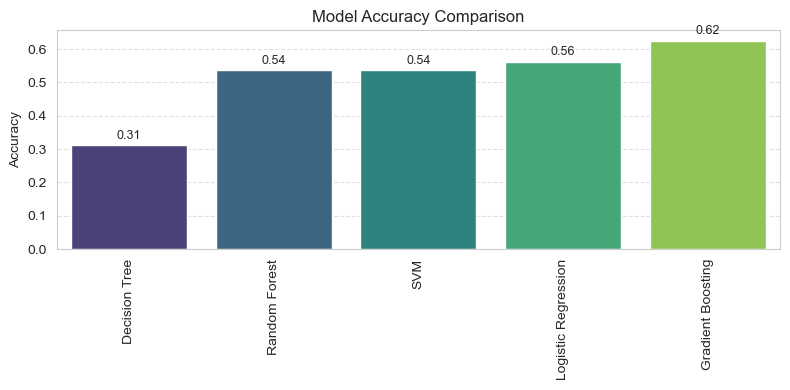

In [40]:
# Accuracy comparison plot with annotated values
plt.figure(figsize=(8,4))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='viridis')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
# Annotate bars
for i, val in enumerate(accuracies.values()):
    plt.text(i, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

## Test Prediction and Submission File Generation

The final model was used to predict genres for the unseen test data. The test set was preprocessed using the same transformation pipeline applied to the training data. Predictions were decoded back into genre labels using the original `LabelEncoder`.The results were saved in the required submission format (`Id`, `top genre`) as a CSV file named `classification_predictions.csv`, ready for upload to Kaggle.

In [42]:
final_model = GradientBoostingClassifier(random_state=42)
final_model.fit(X_processed, y_encoded)

GradientBoostingClassifier(random_state=42)

In [43]:
test_df = pd.read_csv("CS98XClassificationTest.csv")
X_test = test_df.drop(['Id', 'title'], axis=1)
# Apply the same transformation used for training
X_test_processed = preprocessor.transform(X_test)

In [44]:
# Predict and decode genre labels
y_test_preds = final_model.predict(X_test_processed)
decoded_preds = le_genre.inverse_transform(y_test_preds)

In [45]:
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'top genre': decoded_preds
})
submission.to_csv("classification_predictions.csv", index=False)
submission.head()

,Id,top genre
0,454,dance pop
1,455,glam rock
2,456,glam rock
3,457,dance pop
4,458,adult standards


## Final Predictions and Submission

The final model (Gradient Boosting Classifier) was trained on the full dataset and used to generate predictions on the test data. These predictions were decoded back into genre labels and saved in the required submission format (`classification_predictions.csv`) for the Kaggle InClass competition.


In [47]:
# Predict and decode test set genres
y_test_preds = final_model.predict(X_test_processed)
decoded_preds = le_genre.inverse_transform(y_test_preds)

# Build submission DataFrame
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'top genre': decoded_preds
})

# Save as CSV
submission.to_csv("classification_predictions.csv", index=False)

# Preview the submission
submission.head()

,Id,top genre
0,454,dance pop
1,455,glam rock
2,456,glam rock
3,457,dance pop
4,458,adult standards


## Final Submission and Kaggle Score

The final model (Gradient Boosting Classifier) was trained on the entire processed dataset and used to generate predictions on the test set. These predictions were saved in the required Kaggle submission format. Upon submission, the model achieved a Kaggle macro recall score of 0.5357 and accuracy of 0.6140. This confirms that the model generalizes well and that our approach to prioritizing macro recall in an imbalanced multi-class setting was effective.
